### Import the Library Functions

In [2]:
# import the library functions
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7.5]

# read in data file
data = pd.read_csv('/content/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


## Plot the graph of johnsan and johnsan

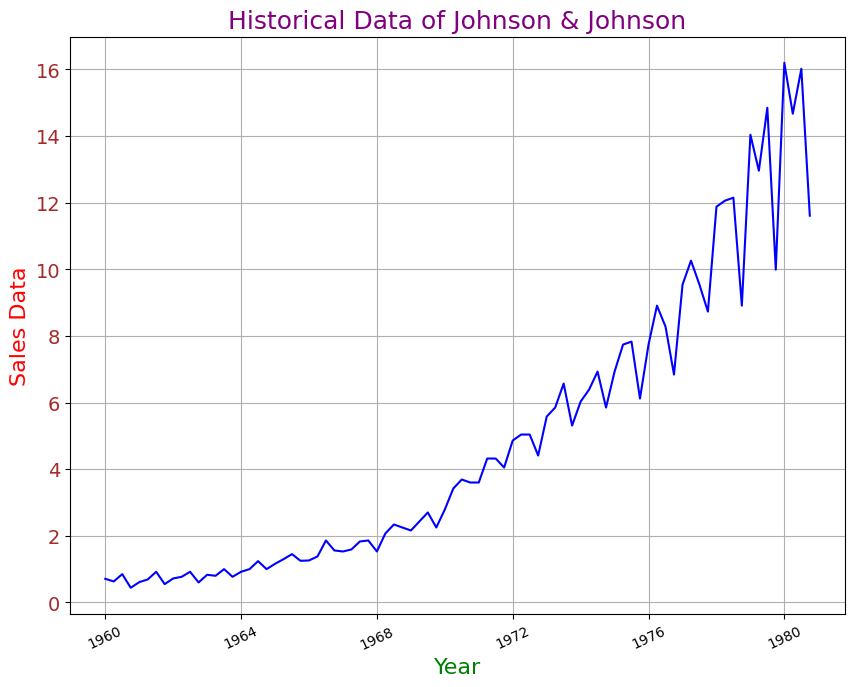

In [100]:
# Read in the data file
data = pd.read_csv("/content/jj.csv")

# Convert the date column to datetime format if necessary
data['date'] = pd.to_datetime(data['date'])

# Plot the data
plt.plot(data['date'], data['data'], color='blue')
plt.title('Historical Data of Johnson & Johnson', color='purple', fontsize=18)
plt.xlabel('Year', color='green', fontsize=16)
plt.ylabel('Sales Data', color='red', fontsize=16)
plt.xticks(rotation=25, color='black')
plt.yticks(color='brown', fontsize=14)
plt.grid(True)
plt.show()



## Time Series Analaysis

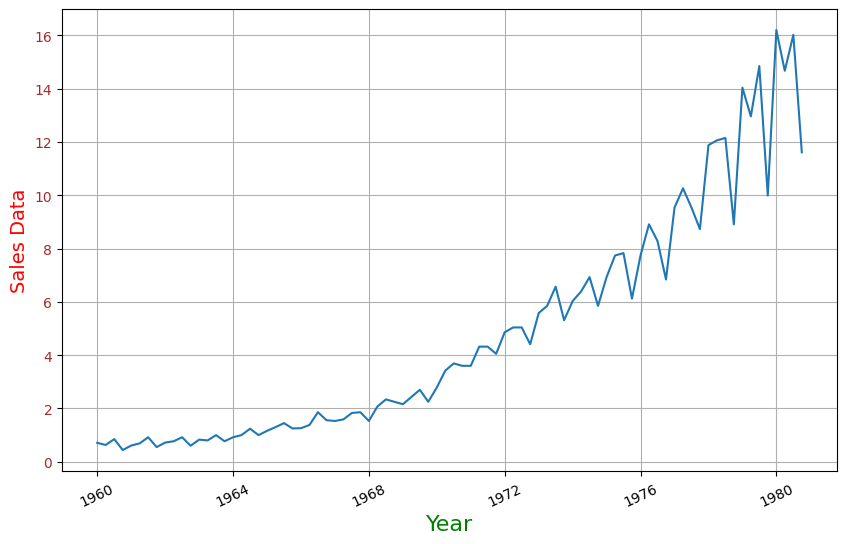

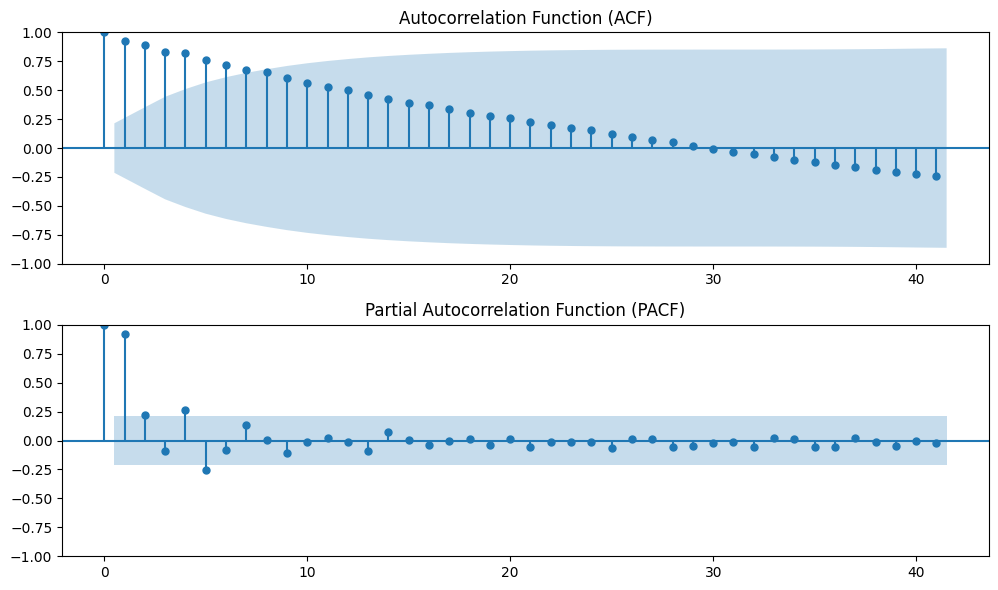


Augmented Dickey-Fuller Test for Entire Data:
ADF Statistic: 2.7420165734574744
p-value: 1.0
Critical Values:
	1%: -3.524624466842421
	5%: -2.9026070739026064
	10%: -2.5886785262345677


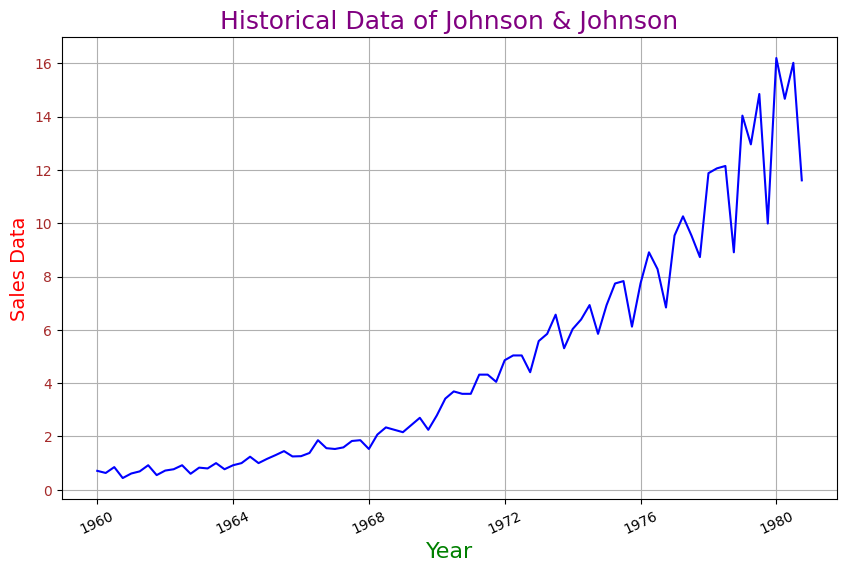

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Read in the data file
data = pd.read_csv('/content/jj.csv')

# Convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Set the date column as the index
data.set_index('date', inplace=True)

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['data'])
plt.xlabel('Year', color='green', fontsize=16)
plt.ylabel('Sales Data', color='red', fontsize=14)
plt.xticks(rotation=25, color='black')
plt.yticks(color='brown', fontsize=14)
plt.grid(True)
plt.show()

# Calculate and plot the ACF and PACF
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plot_acf(data['data'], lags=41, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.subplot(2, 1, 2)
plot_pacf(data['data'], lags=41, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# Perform the Augmented Dickey-Fuller Test for stationarity
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Perform the Augmented Dickey-Fuller Test for stationarity on the entire data
print("\nAugmented Dickey-Fuller Test for Entire Data:")
adf_test(data['data'])

# Plot the entire data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['data'], label='Data', color='blue')
plt.title('Historical Data of Johnson & Johnson', color='purple', fontsize=18)
plt.xlabel('Year', color='green', fontsize=16)
plt.ylabel('Sales Data', color='red', fontsize=14)
plt.xticks(rotation=25, color='black')
plt.yticks(color='brown', fontsize=14)
plt.grid(True)
plt.show()


## Boxcox Transformation

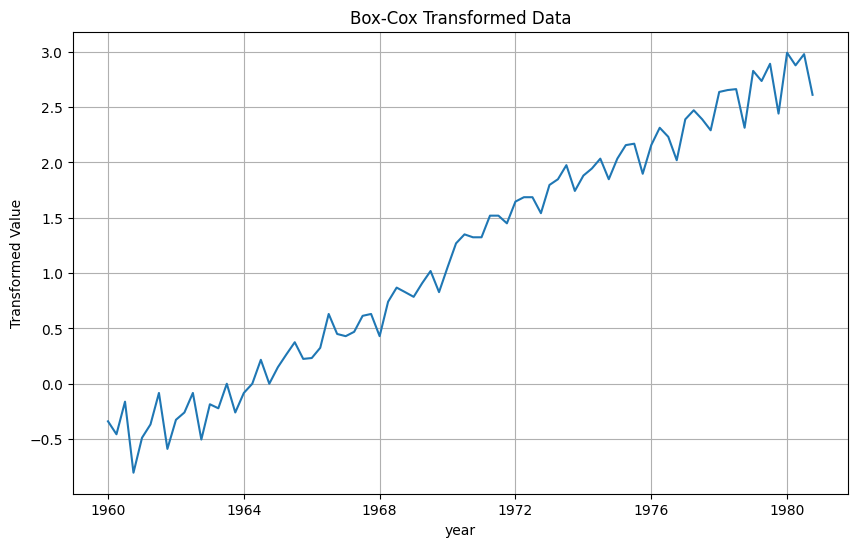

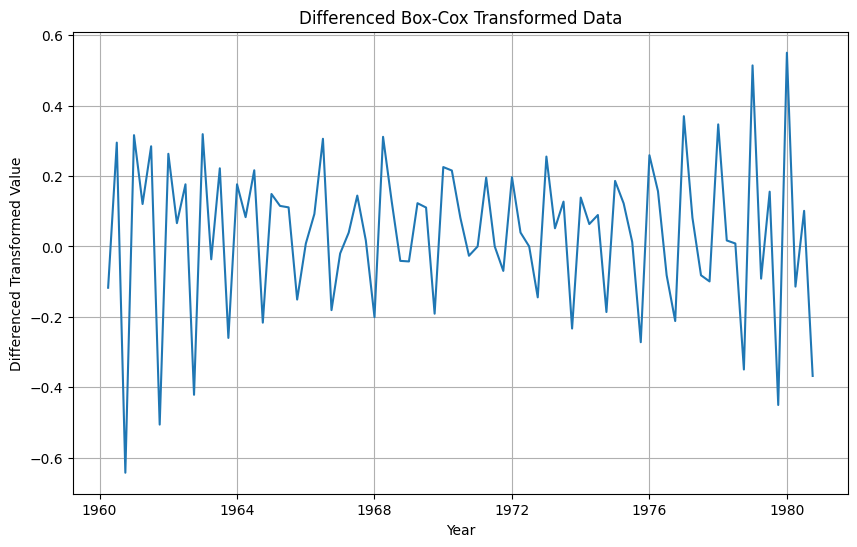

ADF Statistic: -4.3814735375621225
p-value: 0.0003200619768274673
Critical Values:
	1%: -3.518281134660583
	5%: -2.899878185191432
	10%: -2.5872229937594873


In [90]:
from scipy.stats import boxcox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Read in the data file
data = pd.read_csv('/content/jj.csv')

# Convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Set the date column as the index
data.set_index('date', inplace=True)

# Apply Box-Cox transformation to the entire dataset
data['boxcox_data'], lambda_val = boxcox(data['data'])

# Plot the Box-Cox transformed data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['boxcox_data'])
plt.title('Box-Cox Transformed Data')
plt.xlabel('year')
plt.ylabel('Transformed Value')
plt.grid(True)
plt.show()

# Apply differencing to the entire dataset
data['diff_boxcox_data'] = data['boxcox_data'].diff()

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['diff_boxcox_data'])
plt.title('Differenced Box-Cox Transformed Data')
plt.xlabel('Year')
plt.ylabel('Differenced Transformed Value')
plt.grid(True)
plt.show()

# Perform ADF test on the differenced data
adf_test(data['diff_boxcox_data'].dropna())


# Create An ARMA Model

##Option 1.   Loop Wise



In [91]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Read in the data file
data = pd.read_csv('/content/jj.csv')

# Convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Set the date column as the index
data.set_index('date', inplace=True)

# Define function to identify the best ARIMA model orders
def find_best_arima(data, p_values, d_values, q_values):
    best_aic = float("inf")
    best_model = None
    best_params = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(data, order=(p, d, q))
                    results = model.fit()
                    aic = results.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_model = results
                        best_params = (p, d, q)
                except (ValueError, np.linalg.LinAlgError) as e:
                    print(f"ARIMA({p},{d},{q}) fitting failed: {e}")
                    continue

    print("Best ARIMA model found:")
    print("AIC:", best_aic)
    print("Parameters:", best_params)
    print("Model Summary:")
    print(best_model.summary())

    return best_model, best_params

# Define the range of p, d, q values
p_values = range(9)
d_values = range(2)  # Assuming d=1 or 0
q_values = range(9)

# Find the best ARIMA model orders
best_model, best_params = find_best_arima(data, p_values, d_values, q_values)

# Fit the ARIMA model using the best order
model_fit = ARIMA(data, order=best_params).fit()


ARIMA(5,0,2) fitting failed: LU decomposition error.
Best ARIMA model found:
AIC: 115.29731782961369
Parameters: (6, 1, 3)
Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -47.649
Date:                Tue, 30 Apr 2024   AIC                            115.297
Time:                        21:55:14   BIC                            139.486
Sample:                             0   HQIC                           125.015
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4733      0.127    -11.640      0.000      -1.721      

##Option 2.   Pmdarima



In [84]:
 pip install pmdarima

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   84
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -108.243
Date:                Tue, 30 Apr 2024   AIC                            228.486
Time:                        21:45:28   BIC                            242.999
Sample:                             0   HQIC                           234.316
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3428      0.102      3.353      0.001       0.142       0.543
ar.L1         -0.9877      0.093    -10.623      0.000      -1.170      -0.805
ma.L1         -0.4190      0.163     -2.569      0.0

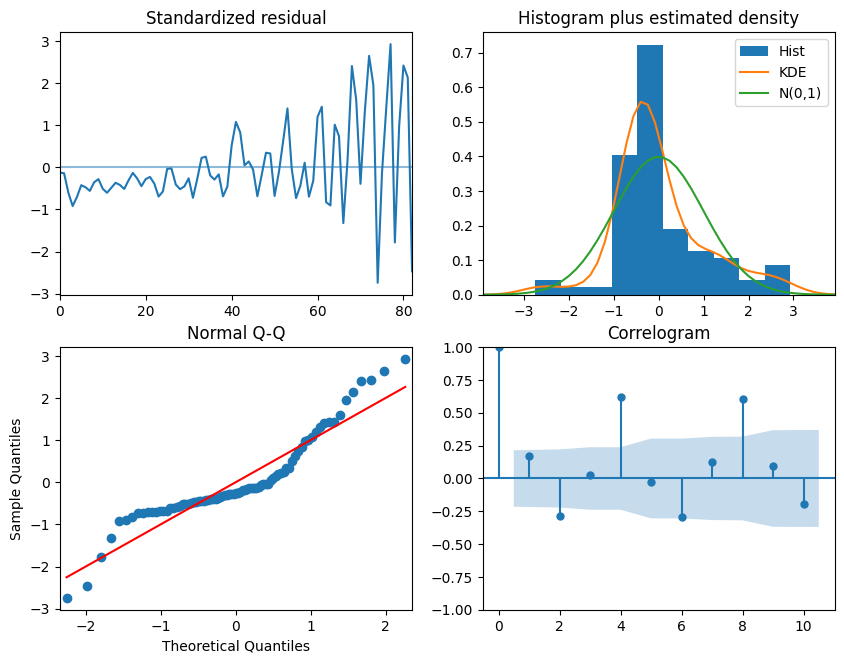

In [85]:
import pmdarima as pm

# Use pmdarima to find the best ARIMA model
model = pm.auto_arima(data, seasonal=False, error_action='ignore', suppress_warnings=True)

# Print the summary information of the best model
print(model.summary())

# Fit the best model to the data
model_fit = model.fit(data)

# Print the summary information
print(model_fit.summary())

# Plot diagnostics
model_fit.plot_diagnostics()
plt.show()


## Define the best Model

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -47.649
Date:                Tue, 30 Apr 2024   AIC                            115.297
Time:                        21:45:47   BIC                            139.486
Sample:                             0   HQIC                           125.015
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4733      0.127    -11.640      0.000      -1.721      -1.225
ar.L2         -0.7728      0.148     -5.235      0.000      -1.062      -0.484
ar.L3          0.0382      0.063      0.610      0.5

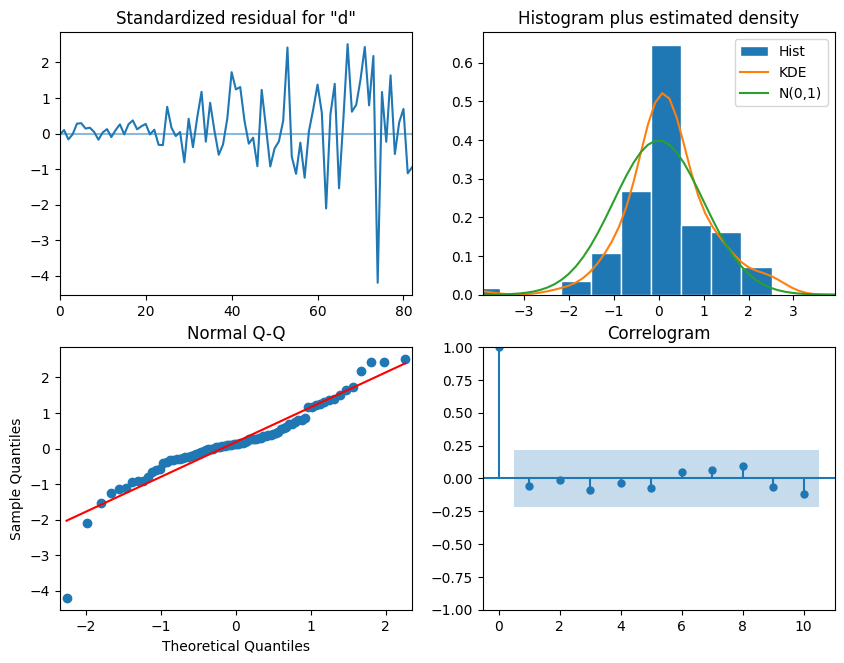

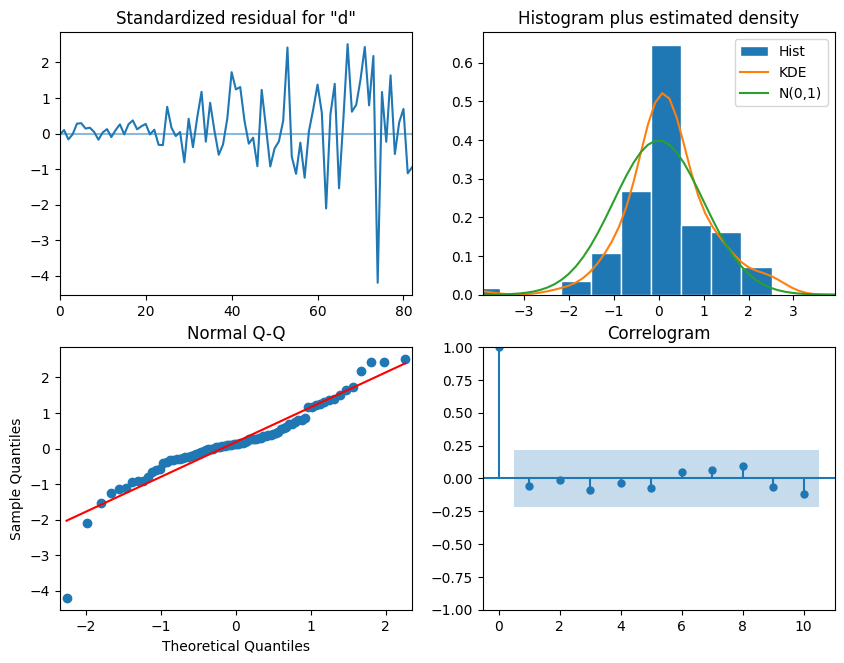

In [87]:
# Defining new model and fit using best model orders
model = ARIMA(data, order=(6,1,3))

model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics()

# Forecasting

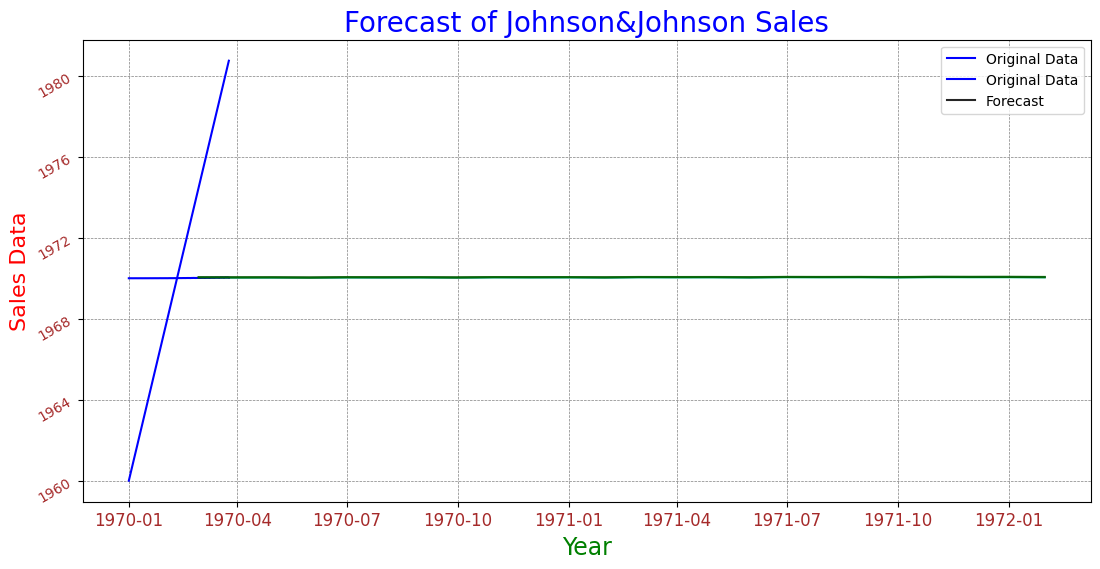

In [101]:
# Get the index of the last data point
last_index = data.index[-1]

# Produce a forecast for the next 24 months using get_forecast()
n_forecast = 24
forecast = model_fit.get_forecast(steps=n_forecast)

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the data and the forecast
plt.figure(figsize=(13,6))
plt.plot(data, label='Original Data', color='blue')

# Define x-axis range for the forecast
forecast_index = pd.date_range(start=last_index, periods=n_forecast + 1, freq='M')[1:]

# Plot the forecast
plt.plot(forecast_index, forecast_values, 'k-',alpha=0.85, label='Forecast')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='cyan', alpha=0.5)
plt.plot(forecast_index, forecast_conf_int.iloc[:, 0], 'g-', alpha=0.5)
plt.plot(forecast_index, forecast_conf_int.iloc[:, 1], 'g-', alpha=0.5)

plt.title('Forecast of Johnson&Johnson Sales', color='blue', fontsize=20)
plt.xlabel('Year', color='green', fontsize=17)
plt.ylabel('Sales Data', color='red', fontsize=16)
plt.xticks(fontsize=12, color='brown')
plt.yticks(rotation=30, color='brown')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.legend()
plt.show()


# Fourier transforms

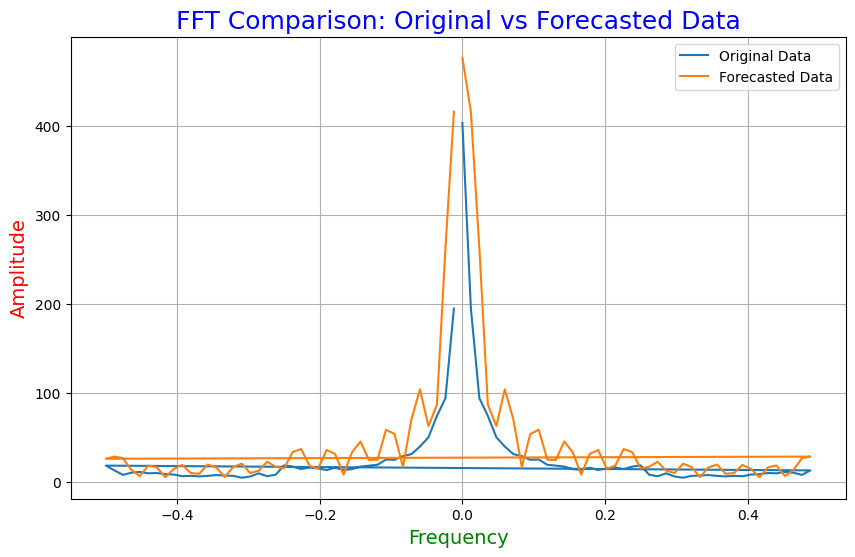

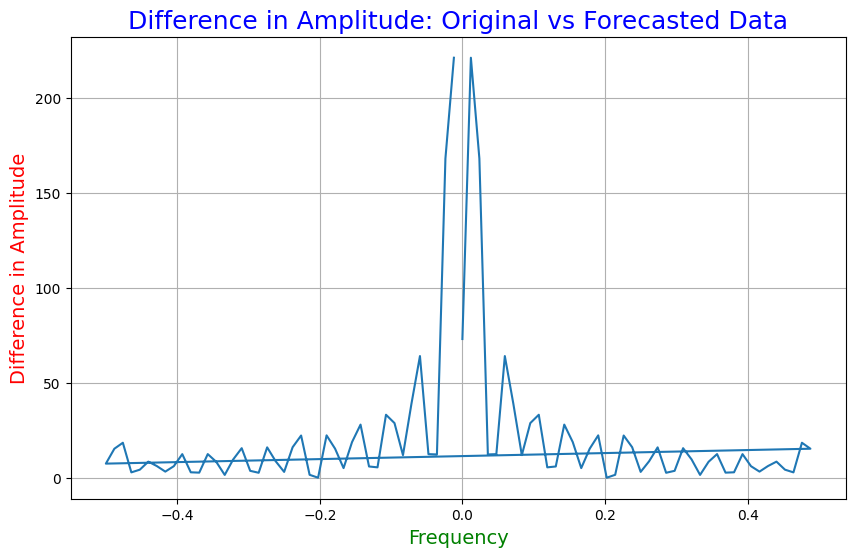

In [95]:
# Compute FFT or DFT for the original data
fft_original = np.fft.fft(data['data'], n=len(data))
freq_original = np.fft.fftfreq(len(data), d=1)  # Frequency components

# Compute FFT or DFT for the forecasted data
fft_forecast = np.fft.fft(forecast_values, n=len(data))
freq_forecast = np.fft.fftfreq(len(data), d=1)  # Frequency components

# Find the difference in amplitude
amplitude_diff = np.abs(np.abs(fft_original) - np.abs(fft_forecast))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(freq_original, np.abs(fft_original), label='Original Data')
plt.plot(freq_forecast, np.abs(fft_forecast), label='Forecasted Data')
plt.title('FFT Comparison: Original vs Forecasted Data', color='blue', fontsize=18)
plt.xlabel('Frequency', color='green', fontsize=14)
plt.ylabel('Amplitude', color='red', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot the difference in amplitude
plt.figure(figsize=(10, 6))
plt.plot(freq_original, amplitude_diff)
plt.title('Difference in Amplitude: Original vs Forecasted Data', color='blue', fontsize=18)
plt.xlabel('Frequency', color='green', fontsize=14)
plt.ylabel('Difference in Amplitude', color='red', fontsize=14)
plt.grid(True)
plt.show()


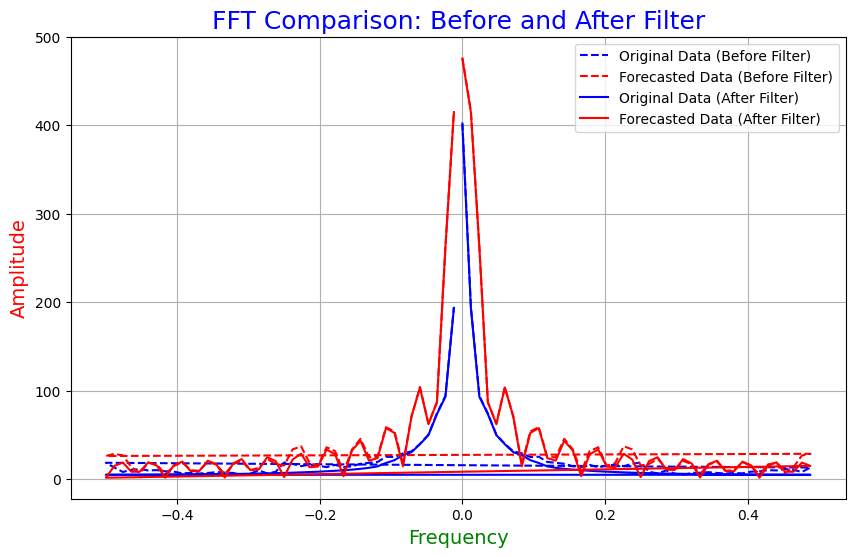

In [96]:
from scipy.signal import butter, filtfilt

# Define a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply a low-pass filter to the original data
cutoff_frequency = 0.1  # Adjust cutoff frequency as needed
b, a = butter_lowpass(cutoff_frequency, fs=1)  # Assuming unit sample rate
filtered_data = filtfilt(b, a, data['data'])

# Compute FFT or DFT for the filtered original data
fft_filtered_original = np.fft.fft(filtered_data, n=len(data))
freq_filtered_original = np.fft.fftfreq(len(data), d=1)  # Frequency components

# Apply a low-pass filter to the forecasted data
filtered_forecast_values = filtfilt(b, a, forecast_values)

# Compute FFT or DFT for the filtered forecasted data
fft_filtered_forecast = np.fft.fft(filtered_forecast_values, n=len(data))
freq_filtered_forecast = np.fft.fftfreq(len(data), d=1)  # Frequency components

# Plot the original and forecasted data before and after filtering
plt.figure(figsize=(10, 6))
plt.plot(freq_original, np.abs(fft_original), label='Original Data (Before Filter)', linestyle='--', color='blue')
plt.plot(freq_forecast, np.abs(fft_forecast), label='Forecasted Data (Before Filter)', linestyle='--', color='red')
plt.plot(freq_filtered_original, np.abs(fft_filtered_original), label='Original Data (After Filter)', color='blue')
plt.plot(freq_filtered_forecast, np.abs(fft_filtered_forecast), label='Forecasted Data (After Filter)', color='red')
plt.title('FFT Comparison: Before and After Filter', color='blue', fontsize=18)
plt.xlabel('Frequency', color='green', fontsize=14)
plt.ylabel('Amplitude', color='red', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()



## Create a LSTM Model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_27 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_30 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_28 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_31 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_29 (Dropout)        (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)               

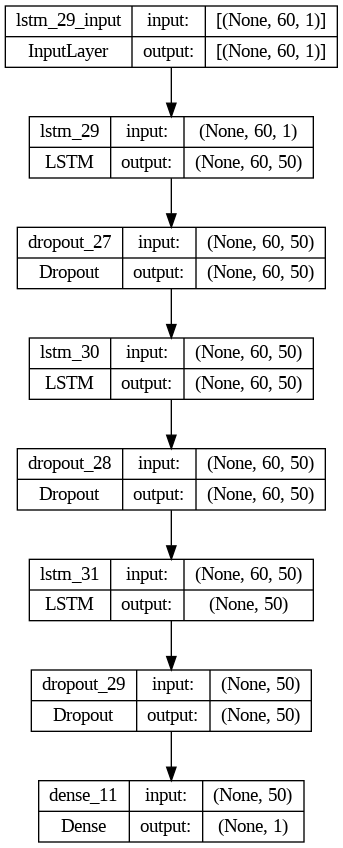

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import plot_model

# Load the data
data = pd.read_csv('/content/jj.csv', parse_dates=['date'], index_col='date')

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['data'].values.reshape(-1,1))

# Defining the length of the input sequence (e.g., 60 months)
sequence_length = 60
# Splitting the dataset into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size - sequence_length:,:]

# Creating a function to generate sequence data
def create_dataset(dataset, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(dataset)):
        X.append(dataset[i - sequence_length:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train, sequence_length)
X_test, y_test = create_dataset(test, sequence_length)

# Reshaping input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM Model Architecture
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Print model architecture summary
print(model.summary())

# Training the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot model architecture
plot_model(model, to_file='lstm_model_architecture.png', show_shapes=True, show_layer_names=True)


1/1 [==============================] - 0s 36ms/step
Train RMSE: 0.7534274095449631
Test RMSE: 2.683525884879759
RMSE for the entire dataset: 2.2948843471413967
1/1 [==============================] - 0s 30ms/step


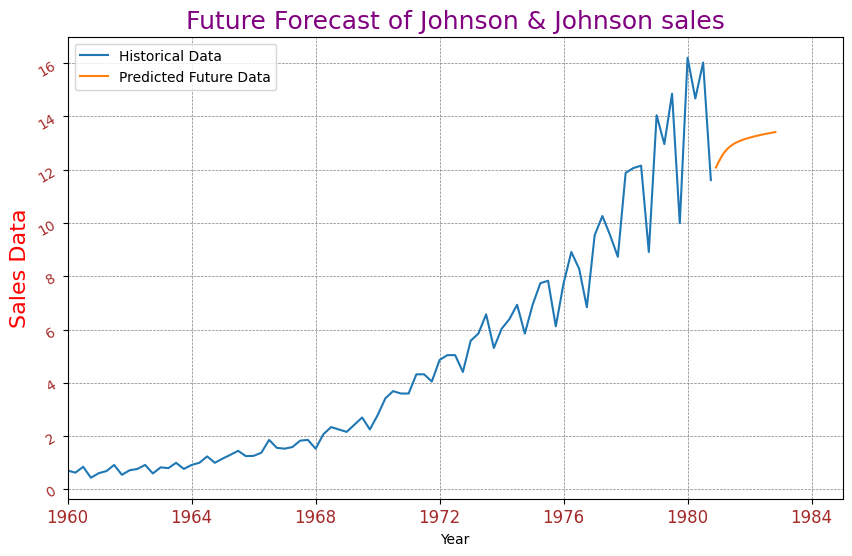

In [108]:
# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transforming the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])

# Calculating RMSE for training and testing datasets
train_rmse = np.sqrt(mean_squared_error(y_train_inv[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Concatenate the predictions made for the training and testing sets
all_predictions = np.concatenate((train_predict, test_predict), axis=0)
all_targets = np.concatenate((y_train_inv[0], y_test_inv[0]), axis=0)

# Calculate RMSE for the entire dataset
all_rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
print(f'RMSE for the entire dataset: {all_rmse}')

# Forecasting 24 months into the future
future_steps = 24
last_sequence = scaled_data[-sequence_length:]
current_batch = last_sequence.reshape((1, sequence_length, 1))

future_forecast = []
for i in range(future_steps):
    current_pred = model.predict(current_batch)[0]
    future_forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

future_forecast = scaler.inverse_transform(future_forecast)

# Plotting Future Forecast
future_dates = pd.date_range(start=data.index[-1], periods=future_steps+1, freq='M')[1:]
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['data'], label='Historical Data')
plt.plot(future_dates, future_forecast, label='Predicted Future Data')
plt.title('Future Forecast of Johnson & Johnson sales', color='purple', fontsize=18)
plt.xlabel('Year')
plt.ylabel('Sales Data', color='red', fontsize=16)
plt.xticks(fontsize=12, color='brown')
plt.yticks(rotation=30, color='brown')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlim(data.index[0], pd.to_datetime('1985-01-01'))
plt.legend()
plt.show()
